Adding PDFs
====

Investigation into using a PDF to describe the combination of multiple distributions.

In [1]:
# Just some boilerplate code

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = (10.0, 8.0)

rng = np.random.default_rng()
pdf_domain = (-3, 7)
pdf_range = (0, 1.0)


def sample(N, pdf):
    """
    Use accept-reject sampling to get N samples from pdf
    
    slow
    
    """
    points = np.zeros(N)
    num_generated = 0

    while num_generated < N:
        # Generate a point
        x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
        y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

        if y < pdf(x):
            points[num_generated] = x
            num_generated += 1

    return points

Consider two distributions and their sum:

In [2]:
# Define two distributions - these aren't normalised
fcn1 = lambda x: 1.2 * norm.pdf(x, loc=0, scale=1)
fcn2 = lambda x: 0.9 * norm.pdf(x, loc=3, scale=1)

# Distributions * efficiency fcn
efficiency = lambda x: 6.6 * norm.pdf(x, loc=2, scale=3)

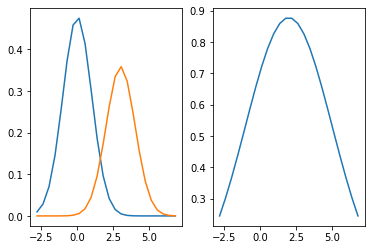

In [3]:
kw = {"histtype": "step", "bins": np.linspace(*pdf_domain, 25), "alpha": 0.8}
centres = (kw["bins"][:-1] + kw["bins"][1:]) / 2

fig, ax = plt.subplots(1, 2)
ax[0].plot(centres, [fcn1(x) for x in centres], label="fcn1")
ax[0].plot(centres, [fcn2(x) for x in centres], label="fcn2")
ax[1].plot(centres, [efficiency(x) for x in centres], label="Efficiency")

In [4]:
# Generate some points of both types with an efficiency function
N1, N2 = 230000, 180000
x1_reco = sample(N1, lambda x: efficiency(x) * fcn1(x))
x2_reco = sample(N2, lambda x: efficiency(x) * fcn2(x))

both_reco = np.concatenate((x1_reco, x2_reco))

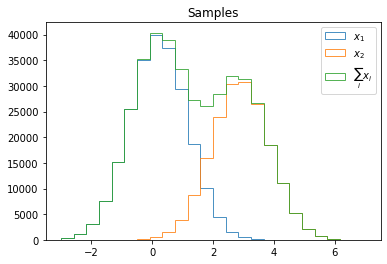

In [5]:
# Plot histograms

plt.hist(x1_reco, **kw, label=r"$x_1$")
plt.hist(x2_reco, **kw, label=r"$x_2$")
plt.hist(both_reco, **kw, label=r"$\sum_ix_i$")
plt.title("Samples")
plt.legend()
plt.show()

Can we extract the efficiency function using only the generating PDFs and the reconstructed distributions?

Hypothesize that the combined PDF is:

$p(x) = I_1p_1(x) + I_2p_2(x)$

Where:

$I_j = \sum_{i=0}^{N_j}\frac{1}{p_j(x_i)}$

Then our efficiency is:

$e(x) = \frac{x_1^{reco} + x_2^{reco}}{I_1x_1 + I_2x_2}$

In [6]:
I1 = 0
I2 = 0

# Iterate over all of the points
for p in x1_reco:
    I1 += 1 / fcn1(p)
for p in x2_reco:
    I2 += 1 / fcn2(p)

# Scale the integrals to something more sensible
scale_factor = I1 + I2
I1 /= scale_factor
I2 /= scale_factor


combined_pdf = lambda x: I1 * fcn1(x) + I2 * fcn2(x)

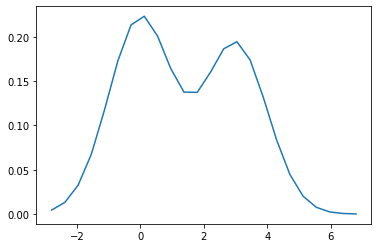

In [7]:
plt.plot(centres, [combined_pdf(x) for x in centres])

In [8]:
# Generate a sample from the combined PDF
x4 = sample(N1 + N2, combined_pdf)

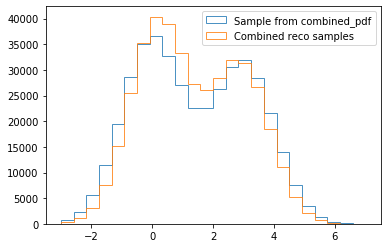

In [9]:
gen, _, _ = plt.hist(x4, **kw, label=r"Sample from combined_pdf")
reco, _, _ = plt.hist(both_reco, **kw, label=r"Combined reco samples")
plt.legend()

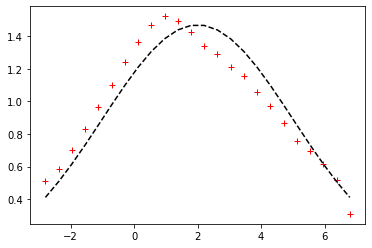

In [10]:
ratio = reco / gen
ratio /= np.mean(ratio)

actual = np.array([efficiency(x) for x in centres])
actual /= np.mean(actual)


plt.plot(centres, ratio, "r+")
plt.plot(centres, actual, "k--")

In [11]:
import datetime
print(datetime.datetime.now().time())

14:55:07.209998
